In [4]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant

## Derivative Behavior / Error Correlation

We are hoping to see high correlation of behavior change in one agent vs error in the other, particularly in times of drastic change. High correlation suggests the agent can use these periods to better infer the error and this parameters of the counterpart based on their future actions.

In [5]:
def matrix_deriv(mat, features, steps):
  trans = mat.transpose()
  deriv = np.empty([features, steps-1])
  for feat in range(len(trans)):
    deriv[feat] = np.diff(trans[feat], 1)
    # for val in range(len(deriv[feat])):
    #   if deriv[feat][val] < 0.000001 and deriv[feat][val] > -0.000001:
    #     deriv[feat][val] = 0.01
  return deriv.transpose()

In [6]:
behav_size = 50
sigmoid_k = 200000000000
sigmoid_b = 20
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(behav_size, behav_size)
B2 = np.random.rand(behav_size, behav_size)
# B1 = np.array([[1]])
# B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.05])
T2 = np.array([.05])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 817


/Users/rpassas/Documents/SoS/sos_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/rpassas/Documents/SoS/sos_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


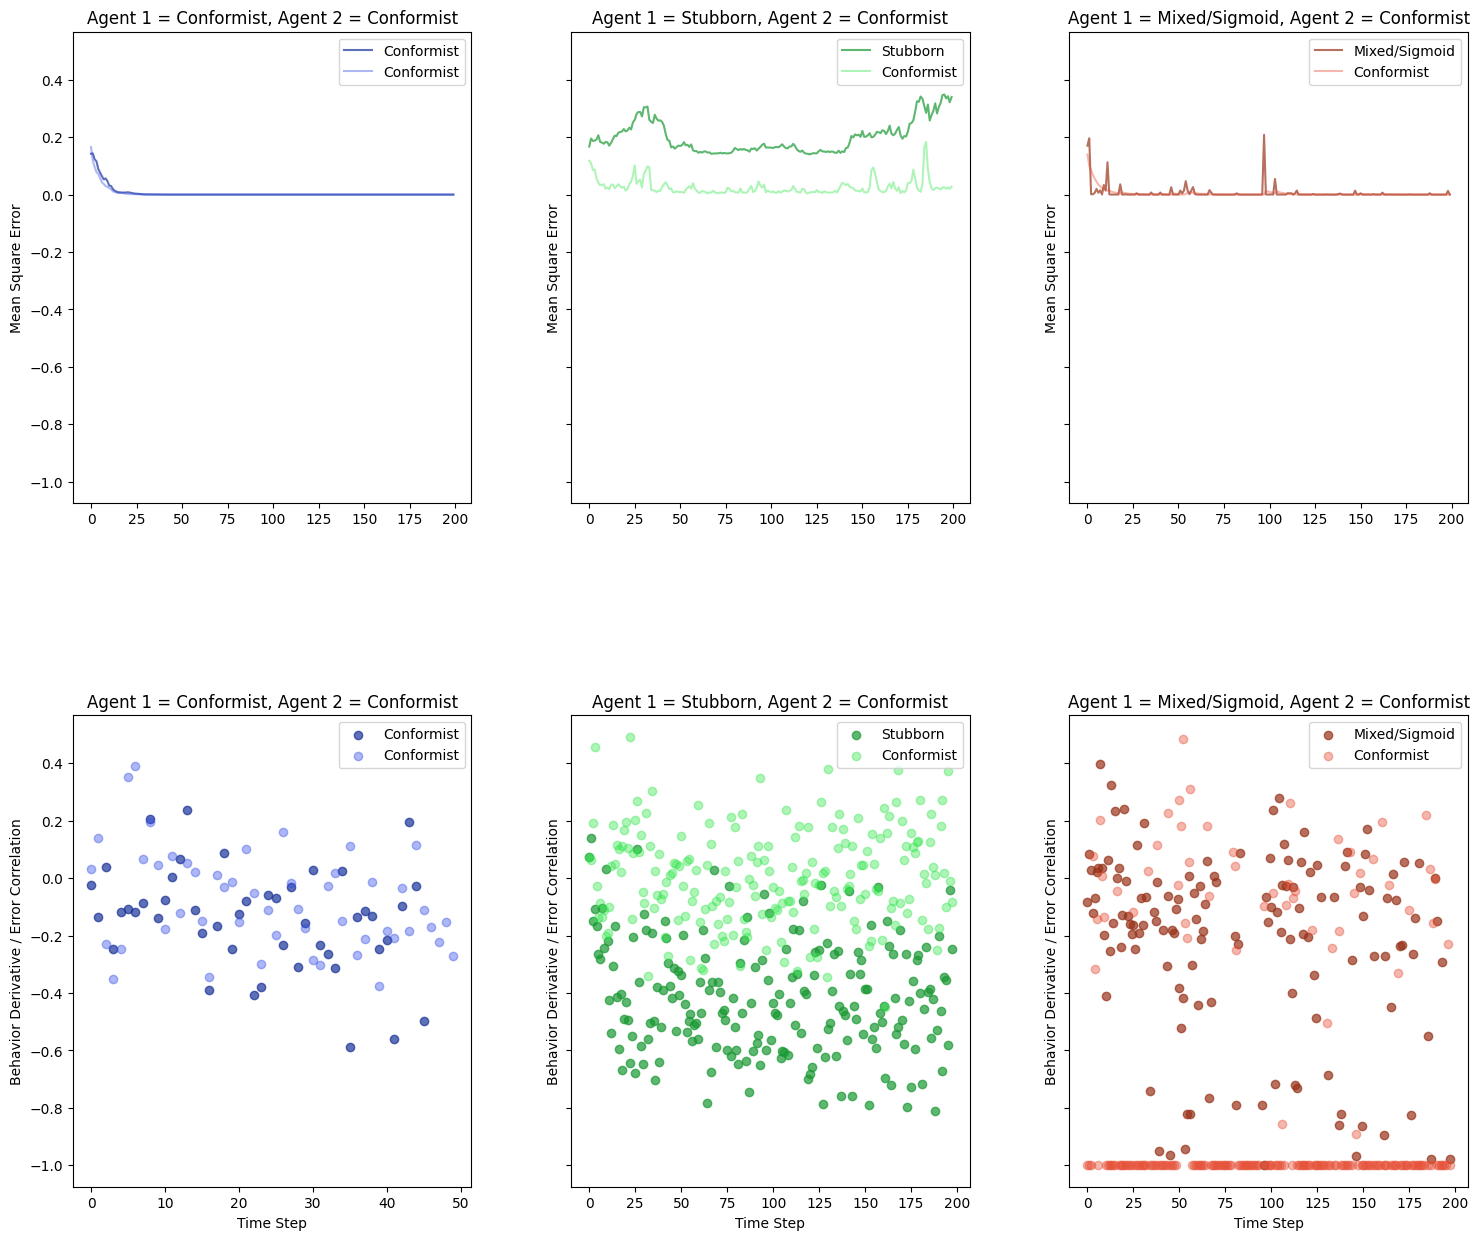

In [7]:
# seed = random.randrange(1000)
seed = 817
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 200
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_raw_error.append(agent1.get_error()[0])
        agent2_raw_error.append(agent2.get_error()[0])
        # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
        #   agent1_raw_error.append(b1[0][0]+0.001)
        # else:
        #   agent1_raw_error.append(agent1.get_error()[0][0])
        # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
        #    agent2_raw_error.append(b2[0][0]+0.001)
        # else:
        #   agent2_raw_error.append(agent2.get_error()[0][0])
        
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    # if agents_label[param] == "Mixed/Sigmoid": 
    #   ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    # ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    # ax[ai].set_xlabel("Time Step")

    # derivative charts
    dx = 1
    # b1_flat = [i[0] for i in agent1_control]
    # b2_flat = [i[0] for i in agent2_control]
    b1_flat = [i[0]for i in agent1_behaviors]
    # print("ag 1 behaviors: ", agent1_behaviors)
    # print("ag 1 flat behaviors: ", b1_flat)
    b2_flat = [i[0]for i in agent2_behaviors]
    # d_behav1 = abs(np.gradient(b1_flat, dx))
    # d_behav2 = abs(np.gradient(b2_flat, dx))
    # d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
    d_behav1 = matrix_deriv(np.array(b1_flat), behav_size, trials)[:-1]
    # print("ag 1 behav deriv: ", d_behav1)
    # d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
    d_behav2 = matrix_deriv(np.array(b2_flat), behav_size, trials)[:-1]
    # print("agent1_raw_error: ", agent1_raw_error)
    # agent1_raw_error.insert(-1, 1)
    # print("agent1_raw_error inserted: ", agent1_raw_error)
    # agent2_raw_error.insert(-1, 1)
    agent1_raw_error_shifted = agent1_raw_error[2:]
    agent2_raw_error_shifted = agent2_raw_error[2:]

    # print(agents_label[param%3], "ratio: ", np.average(abs(d_behav1/agent2_raw_error_shifted)))
    # print(agents_label[0], "ratio: ", np.average(abs(d_behav2/agent1_raw_error_shifted)))
    # print(agents_label[param%3], "+ Conformist covariance:", np.cov(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted)))
    # print(agents_label[0], "&",agents_label[param%3], "covariance:", np.cov(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted)))
    # print(agents_label[param%3], "& Conformist Pearson R:", np.corrcoef(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted))[0][1])
    # print(agents_label[0], "&", agents_label[param%3], " Pearson R:", np.corrcoef(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted))[0][1])
    # print("---")

    # print(agents_label[param])
    # print("error: ", agent2_raw_error_shifted)
    # print("d_behav: ", d_behav1)
    coef1 = [np.corrcoef(d_behav1[i], agent2_raw_error_shifted[i])[0][1] for i in range(len(d_behav1))]
    # print(coef1)
    coef2 = [np.corrcoef(d_behav2[i], agent1_raw_error_shifted[i])[0][1] for i in range(len(d_behav2))]
    
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef1, color=color, label="{}".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted), color=color, label="{}".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef2, color=color_c, label="Conformist")
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted), color=color_c, label="Conformist")

    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    # ax[ai].set_ylim(0,1)
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Derivative / Error Correlation")
    ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")

plt.show()

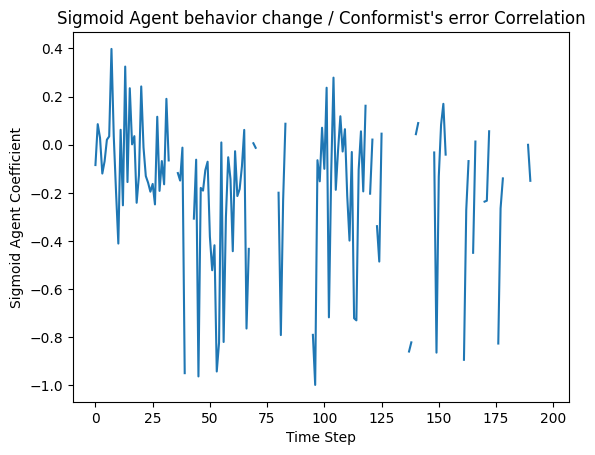

In [13]:
# Sample data
y = coef1
x = range(trials-2)

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Sigmoid Agent Coefficient')
plt.title("Sigmoid Agent behavior change / Conformist's error Correlation")

# Show the plot
plt.show()

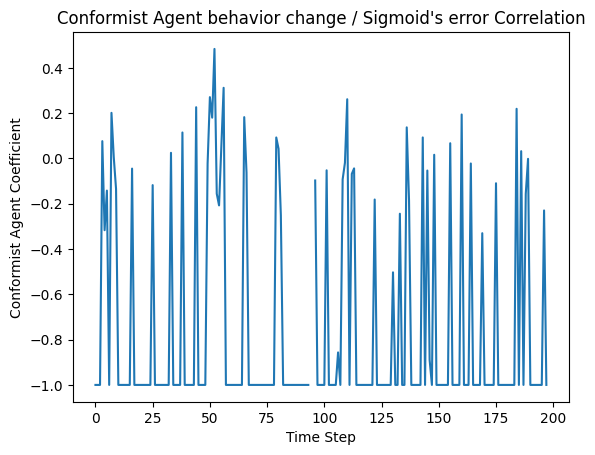

In [14]:
# Sample data
y = coef2
x = range(trials-2)

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Conformist Agent Coefficient')
plt.title("Conformist Agent behavior change / Sigmoid's error Correlation")

# Show the plot
plt.show()

### Increasing 0 values to avoid division issues

In [163]:
behav_size = 50
sigmoid_k = 200000000000
sigmoid_b = 20
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(behav_size, behav_size)
B2 = np.random.rand(behav_size, behav_size)
# B1 = np.array([[1]])
# B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.05])
T2 = np.array([.05])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 732
Avg absolute 1:
0.03391559660883077
Avg absolute 2:
0.0376500845923231
Top 10 minimum coefficients and their indices:
Value: -0.45272401106263954, Index: 27
Value: -0.37142032884133125, Index: 44
Value: -0.30708522122802495, Index: 13
Value: -0.30248888177889166, Index: 45
Value: -0.2664707351746954, Index: 23
Value: -0.24525517254109716, Index: 5
Value: -0.2449659344897961, Index: 34
Value: -0.24099721038080046, Index: 35
Value: -0.23814092614773794, Index: 41
Value: -0.2219964098871784, Index: 37
Value: -0.22100308546973, Index: 3
Value: -0.20982711970484294, Index: 16
Value: -0.18704111773817247, Index: 30
Value: -0.18024508623179045, Index: 12
Value: -0.17919821750882003, Index: 32
Value: -0.17801427582625162, Index: 11
Value: -0.17480285989477037, Index: 4
Value: -0.17227341027027743, Index: 46
Value: -0.16485902700916563, Index: 0
Value: -0.15955452292095645, Index: 9
Top 10 error indices: 
Value: 2.017813063036119e-19, Index: 199
Value: 2.491127243054063e-19, Index

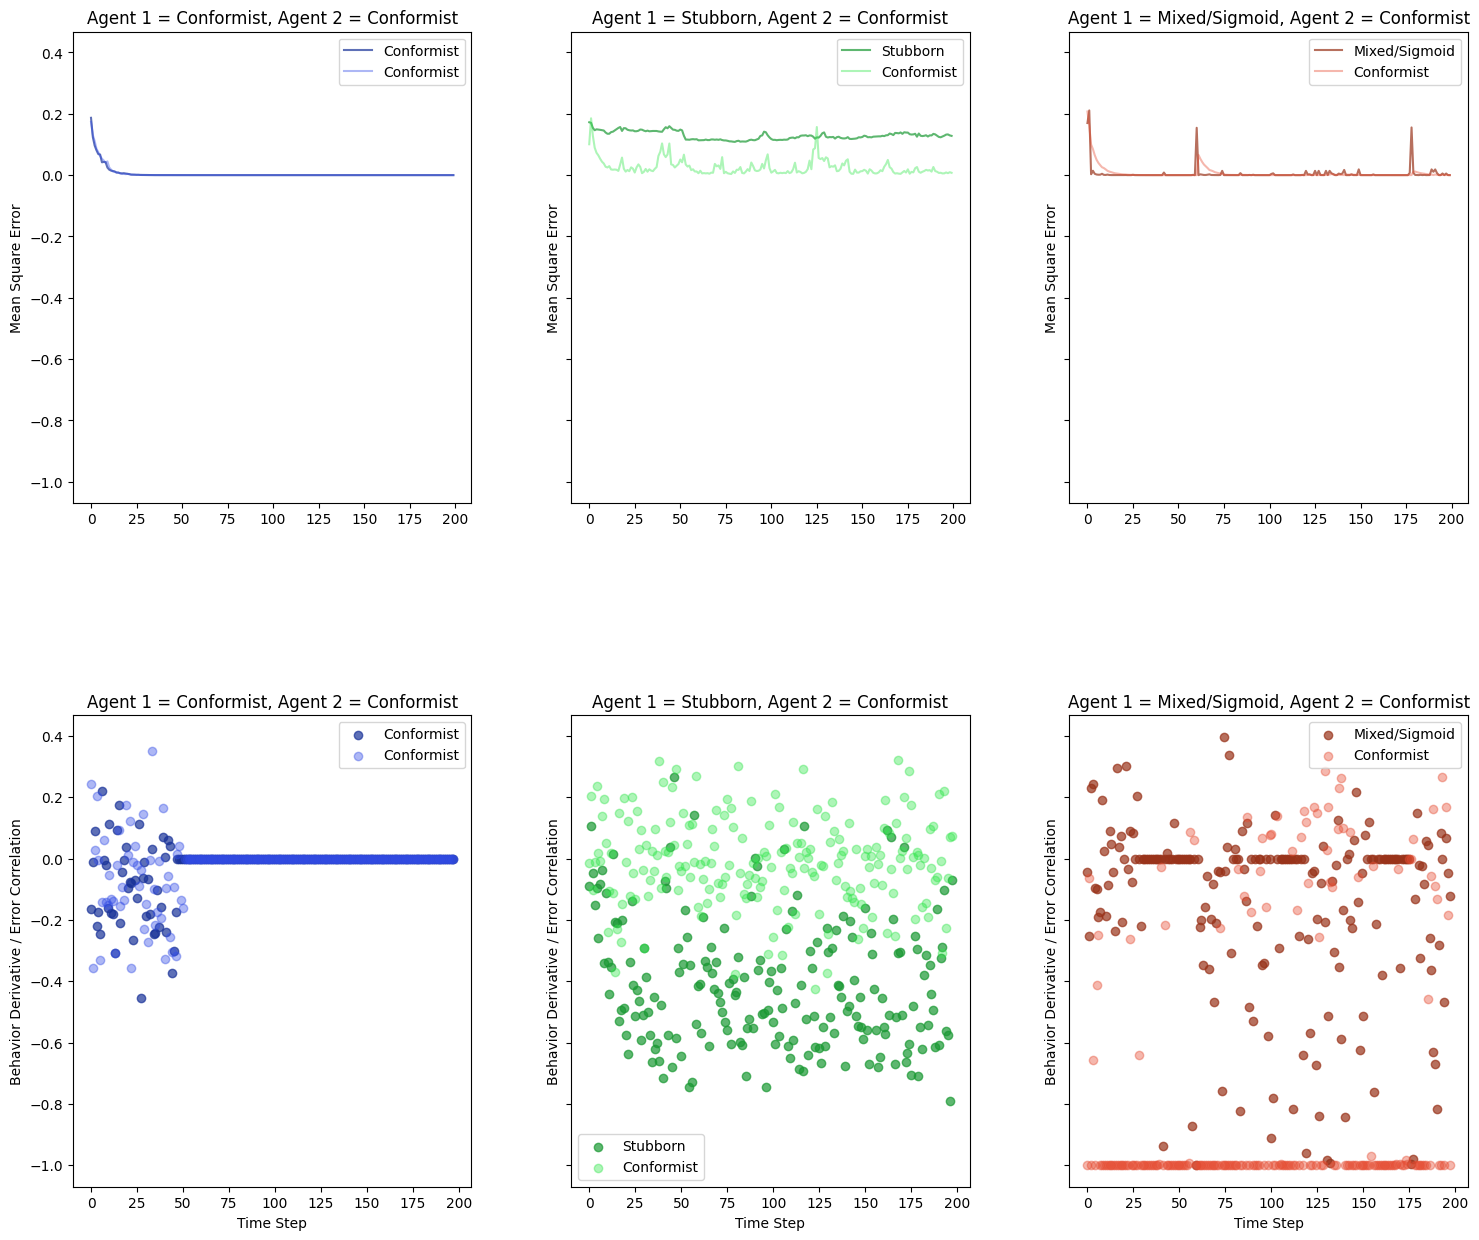

In [168]:
# seed = random.randrange(1000)
seed = 732
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 200
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

# e_1 = []
# e_2 = []
# d_1 = []
# d_2 = []

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        agent1_raw_error.append(agent1.get_error()[0])
        agent2_raw_error.append(agent2.get_error()[0])
        
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    color = colors[param]
    color_c = colors_c[param]

    # e_1.append(agent1_error)
    # e_2.append(agent2_error)
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")

    # derivative charts
    dx = 1
    b1_flat = [i[0]for i in agent1_behaviors]
    b2_flat = [i[0]for i in agent2_behaviors]
    d_behav1 = matrix_deriv(np.array(b1_flat), behav_size, trials)[:-1]
    d_behav2 = matrix_deriv(np.array(b2_flat), behav_size, trials)[:-1]
    agent1_raw_error_shifted = agent1_raw_error[2:]
    agent2_raw_error_shifted = agent2_raw_error[2:]

    min_val = 0.0001
    coef1 = []
    coef2 = []
    for i in range(len(d_behav1)):
       d_behav_1 = d_behav1[i]
       d_behav_2 = d_behav2[i]
       error_1 = agent1_raw_error_shifted[i]
       error_2 = agent2_raw_error_shifted[i]
       for d in range(len(d_behav_1)):
          if abs(d_behav_1[d]) < min_val: 
            d_behav_1[d] = min_val
          if abs(d_behav_2[d]) < min_val: 
            d_behav_2[d] = min_val
       coef1.append(np.corrcoef(d_behav_1, error_2)[0][1])
       coef2.append(np.corrcoef(d_behav_2, error_1)[0][1])
    # Get the indices of the sorted list
    sorted_indices = sorted(range(len(coef1)), key=lambda i: coef1[i])
    sorted_indices_error = sorted(range(len(agent1_error)), key=lambda i: agent1_error[i])

    # Get the top 5 minimum values and their indices
    top_10_min_values = [(coef1[i], i) for i in sorted_indices[:20]]
    top_min_error = [(agent1_error[i], i) for i in sorted_indices_error if agent1_error[i] < 0.000001]


    print("Avg absolute 1:")
    print(np.mean(np.abs(coef1)))
    print("Avg absolute 2:")
    print(np.mean(np.abs(coef2)))
    print("Top 10 minimum coefficients and their indices:")
    top_min = []
    indices= []
    for value, index in top_10_min_values:
        print(f"Value: {value}, Index: {index}")
        # if sigmoid_value:
        #   print(f"Sigmoid Value: {sigmoid_value[index]}")
        # top_min.append(value)
    print("Top 10 error indices: ")
    for value, index in top_min_error:
        print(f"Value: {value}, Index: {index}")
        if index >= len(coef1)-1:
           continue     
        top_min.append(coef1[index])
        indices.append(index)
    print('Avg top coef from low error spots:')
    print(np.mean(np.abs(top_min)))
    print(top_min)
    print(indices)
    print('-----')
    
    
    # d_1.append(coef1)
    # d_2.append(coef2)
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef1, color=color, label="{}".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef2, color=color_c, label="Conformist")

    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    # ax[(ai[0]+1,ai[1])].set_ylim(-1,1)
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Derivative / Error Correlation")
    ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")

plt.show()

In [167]:
print(agent1_error[57:62])
# print(agent2_error[97:103])
# print(d_behav1[98:103])
print('-----------------')
print(coef1[57:62])

[1.4924725908139545e-07, 0.0008994163278923439, 0.0, 0.15441591446220357, 2.000096842998146e-06]
-----------------
[-0.8722671759288343, -1.8367728628607562e-16, -0.9974295729028535, -1.2073687103842093e-15, -0.2219406173408005]


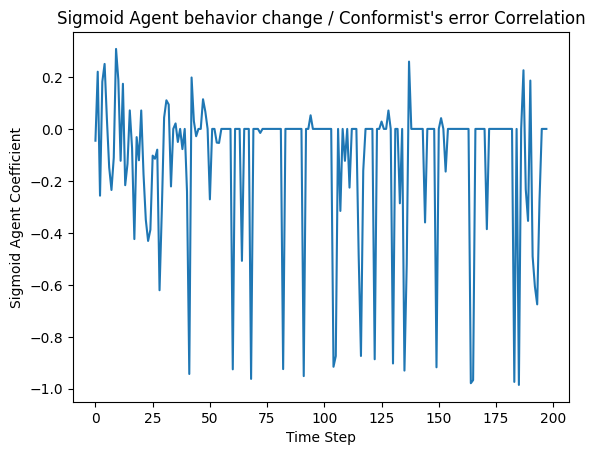

In [62]:
# Sample data
y = coef1
x = range(trials-2)

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Sigmoid Agent Coefficient')
plt.title("Sigmoid Agent behavior change / Conformist's error Correlation")

# Show the plot
plt.show()

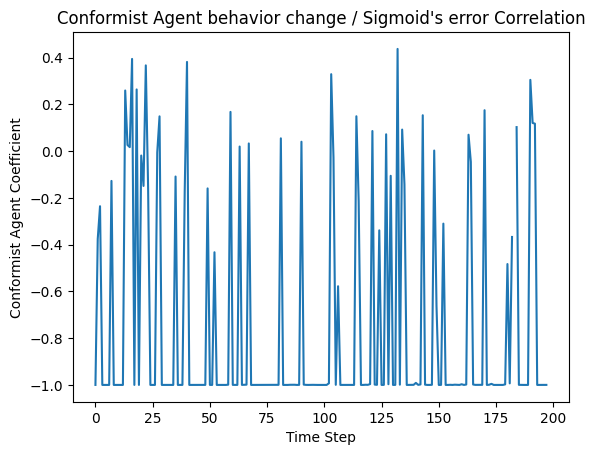

In [63]:
# Sample data
y = coef2
x = range(trials-2)

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Conformist Agent Coefficient')
plt.title("Conformist Agent behavior change / Sigmoid's error Correlation")

# Show the plot
plt.show()